In [1]:
import matplotlib.pyplot as plt
import numpy as np
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARMA
import pandas as pd

In [2]:
def perform_adf_test(series):
    result = adfuller(series)
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])

# Original Series

In [5]:
ts = pd.read_csv('original_series.csv')
ts.index = np.arange(1,len(ts)+1)

In [6]:
ts

,0
1,956.438486
2,7284.907174
3,11357.870166
4,13622.652007
5,17137.455304
...,...
68,42204.338905
69,42368.641039
70,42564.988401
71,42606.297399


Text(0, 0.5, 'Views')

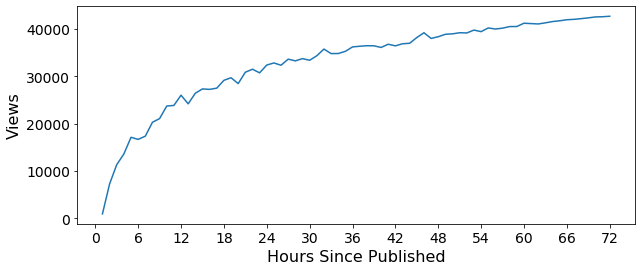

In [7]:
plt.figure(figsize=(10,4))
plt.plot(ts)

plt.xticks(np.arange(0,78,6), fontsize=14)
plt.xlabel('Hours Since Published', fontsize=16)

plt.yticks(np.arange(0,50000,10000), fontsize=14)
plt.ylabel('Views', fontsize=16)

# Original Series: $v_t$

# (1) Normalize ($v_t \rightarrow n_t$): $n_t = \frac{v_t - \mu}{\sigma}$

# (2) Exponentiate ($n_t \rightarrow e_t$): $e_t = e^{n_t}$

# (3) First Difference ($e_t \rightarrow d_t$): $d_t = e_t - e_{t-1}$

# $d_t = e^{\frac{v_t - \mu}{\sigma}} - e^{\frac{v_{t-1} - \mu}{\sigma}}$

# ------------------------------------------------------------

### (1) Normailize - To reduce the scale of the series
### (2) Exponential - To make the series linear (Variance Invariant)
### (3) First Difference - To make it mean invariant (Remove trend)

# (1) Normalize

In [10]:
mu = np.mean(ts).iloc[0]
sigma = np.std(ts).iloc[0]

In [11]:
norm_ts = (ts - mu) / sigma

In [12]:
norm_ts

,0
1,-3.559113
2,-2.858623
3,-2.407791
4,-2.157105
5,-1.768056
...,...
68,1.006566
69,1.024753
70,1.046486
71,1.051059


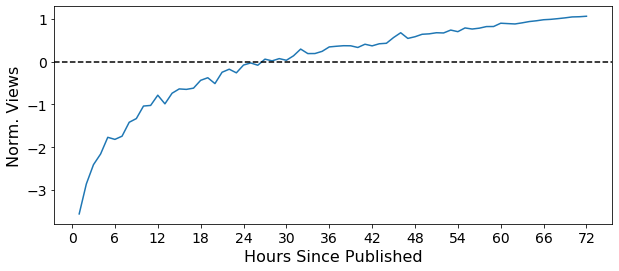

In [13]:
plt.figure(figsize=(10,4))
plt.plot(norm_ts)

plt.xticks(np.arange(0,78,6), fontsize=14)
plt.xlabel('Hours Since Published', fontsize=16)

plt.yticks(np.arange(-3,2), fontsize=14)
plt.ylabel('Norm. Views', fontsize=16)

plt.axhline(0, color='k', linestyle='--')

# (2) Exponentiate

In [14]:
exp_ts = np.exp(norm_ts)

In [15]:
exp_ts

,0
1,0.028464
2,0.057348
3,0.090014
4,0.115659
5,0.170664
...,...
68,2.736190
69,2.786407
70,2.847628
71,2.860678


Text(0, 0.5, 'Exp. Norm. Views')

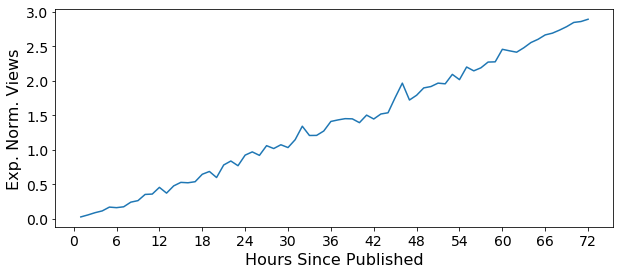

In [16]:
plt.figure(figsize=(10,4))
plt.plot(exp_ts)

plt.xticks(np.arange(0,78,6), fontsize=14)
plt.xlabel('Hours Since Published', fontsize=16)

plt.yticks(np.arange(0,3.5,.5), fontsize=14)
plt.ylabel('Exp. Norm. Views', fontsize=16)

In [17]:
perform_adf_test(exp_ts)

ADF Statistic: 1.648979
p-value: 0.997997


# (3) First Difference

In [18]:
diff_ts = exp_ts.diff().dropna()

In [19]:
diff_ts

,0
2,0.028884
3,0.032666
4,0.025646
5,0.055005
6,-0.008073
...,...
68,0.044267
69,0.050217
70,0.061221
71,0.013050


Text(0, 0.5, 'First Diff. \nExp. Norm. Views')

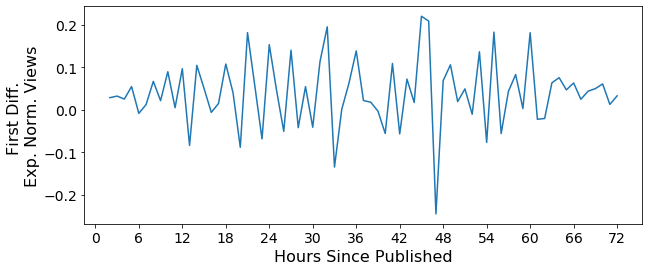

In [20]:
plt.figure(figsize=(10,4))
plt.plot(diff_ts)

plt.xticks(np.arange(0,78,6), fontsize=14)
plt.xlabel('Hours Since Published', fontsize=16)

plt.yticks(np.arange(-0.2,0.3,.1), fontsize=14)
plt.ylabel('First Diff. \nExp. Norm. Views', fontsize=16)

In [21]:
perform_adf_test(diff_ts)

ADF Statistic: -4.881064
p-value: 0.000038


# Fit AR Model

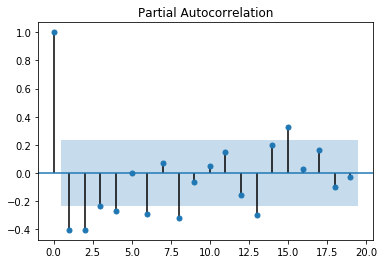

In [22]:
plot_pacf(diff_ts)
plt.show()

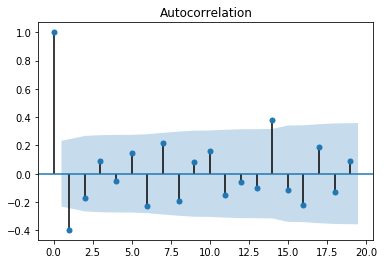

In [23]:
plot_acf(diff_ts)
plt.show()

In [24]:
#create the model
model = ARMA(diff_ts, order=(4,1))

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:214: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


In [25]:
model_fit = model.fit()

# Predict Out 3 Hours

In [27]:
prediction_info = model_fit.forecast(3)
prediction_info

(array([0.04604695, 0.04125667, 0.0415275 ]),
 array([0.06405816, 0.07968378, 0.0804826 ]),
 array([[-0.07950473,  0.17159862],
        [-0.11492068,  0.19743401],
        [-0.1162155 ,  0.19927051]]))

In [28]:
predictions = prediction_info[0]
predictions

array([0.04604695, 0.04125667, 0.0415275 ])

In [29]:
lower_bound = prediction_info[2][:,0]
lower_bound

array([-0.07950473, -0.11492068, -0.1162155 ])

In [30]:
upper_bound = prediction_info[2][:,1]
upper_bound

array([0.17159862, 0.19743401, 0.19927051])

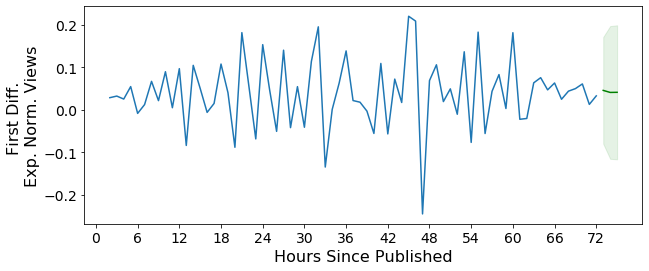

In [31]:
plt.figure(figsize=(10,4))
plt.plot(diff_ts)

plt.xticks(np.arange(0,78,6), fontsize=14)
plt.xlabel('Hours Since Published', fontsize=16)

plt.yticks(np.arange(-0.2,0.3,.1), fontsize=14)
plt.ylabel('First Diff. \nExp. Norm. Views', fontsize=16)

plt.plot(np.arange(len(ts)+1, len(ts)+4), predictions, color='g')
plt.fill_between(np.arange(len(ts)+1, len(ts)+4), lower_bound, upper_bound, color='g', alpha=0.1)

# Undo Transformations: ($\hat{d}_{t+1} \rightarrow \hat{v}_{t+1}$)

# $\hat{v}_{t+1} = \sigma \ln(\hat{d}_{t+1} + e^{\frac{v_t - \mu}{\sigma}}) + \mu$

In [32]:
def undo_transformations(predictions, series, mu, sigma):
    first_pred = sigma*np.log(predictions[0] + np.exp((series.iloc[-1]-mu)/sigma)) + mu
    orig_predictions = [first_pred]
    
    for i in range(len(predictions[1:])):
        next_pred = sigma*np.log(predictions[i+1] + np.exp((orig_predictions[-1]-mu)/sigma)) + mu
        orig_predictions.append(next_pred)
    
    return np.array(orig_predictions).flatten()

In [33]:
orig_preds = undo_transformations(predictions, ts, mu, sigma)
orig_lower_bound = undo_transformations(lower_bound, ts, mu, sigma)
orig_upper_bound = undo_transformations(upper_bound, ts, mu, sigma)

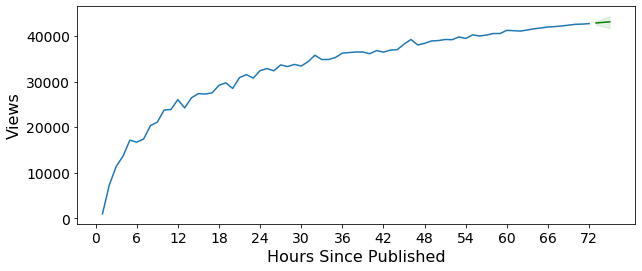

In [34]:
plt.figure(figsize=(10,4))
plt.plot(ts)

plt.xticks(np.arange(0,78,6), fontsize=14)
plt.xlabel('Hours Since Published', fontsize=16)

plt.yticks(np.arange(0,50000,10000), fontsize=14)
plt.ylabel('Views', fontsize=16)

plt.plot(np.arange(len(ts)+1, len(ts)+4), orig_preds, color='g')
plt.fill_between(np.arange(len(ts)+1, len(ts)+4), orig_lower_bound, orig_upper_bound, color='g', alpha=0.1)

(40000, 45000)

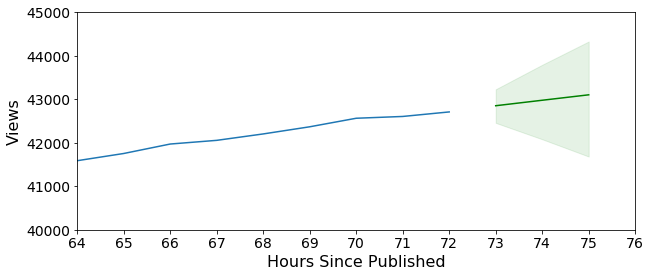

In [35]:
plt.figure(figsize=(10,4))
plt.plot(ts)

plt.xticks(np.arange(0,78), fontsize=14)
plt.xlabel('Hours Since Published', fontsize=16)

plt.yticks(np.arange(40000,46000,1000), fontsize=14)
plt.ylabel('Views', fontsize=16)

plt.plot(np.arange(len(ts)+1, len(ts)+4), orig_preds, color='g')
plt.fill_between(np.arange(len(ts)+1, len(ts)+4), orig_lower_bound, orig_upper_bound, color='g', alpha=0.1)
plt.xlim(64,76)
plt.ylim(40000, 45000)